# Installing Dependencies

In [1]:
!pip install torchmetrics mlflow optuna pyngrok optuna-integration[mlflow] -q --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


# Importing Libraries

In [2]:
# For loading the data
import os
from google.colab import userdata
from zipfile import ZipFile

# For getting data in the right format
import pandas as pd

# For finding vocabulary of textual data
import spacy
from collections import Counter

# For viewing and preprocessing images
from PIL import Image

# For Dataset and Data Loading
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

# For train test split of data
import shutil
from sklearn.model_selection import train_test_split

# For plotting images
import matplotlib.pyplot as plt

# For model architecture
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# For training loop
from tqdm import tqdm
from torchmetrics.text import BLEUScore, ROUGEScore

# For hyperparameter tuning and experiment tracking
import optuna
import mlflow.pytorch
from pyngrok import ngrok
import subprocess
import nltk
from optuna.integration.mlflow import MLflowCallback
nltk.download('punkt')
from IPython.display import FileLink

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
import nltk

# Try user's home directory instead
home = os.path.expanduser("~")
nltk.download('punkt', download_dir=os.path.join(home, 'nltk_data'))

# Add this path to NLTK's search paths
nltk.data.path.append(os.path.join(home, 'nltk_data'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
print(torch.cuda.is_available())

True


# Loading the Dataset

In [5]:
##!kaggle datasets download adityajn105/flickr8k

In [6]:
# data_path = '/kaggle/working/flickr8k.zip'
# if not os.path.exists(data_path):
#   os.mkdir(data_path)
# with ZipFile('/kaggle/working/flickr8k.zip') as zip:
#   zip.extractall(data_path)

In [7]:
data_path = '/kaggle/input/flickr8k'
caption_file = data_path + '/captions.txt'
df = pd.read_csv(caption_file)
print("No. of (Image, Caption) pairs: ", len(df))
df.head(10)

No. of (Image, Caption) pairs:  40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


**As we can see here, our dataset has for every image, 5 different captions**

# Data Preprocessing

In [8]:
spacy_eng = spacy.load("en_core_web_sm")

# Spacy tokenization example
text = "Skill Assessment Model: Validates and assesses skills from resumes, certifications, or projects. This resume parsing is done in a 2 step process - Performs OCR on user's resume to extract text, then uses Groq models to extract user data in json format for storage in database and user profile creation"
print([token.text.lower() for token in spacy_eng.tokenizer(text)])

['skill', 'assessment', 'model', ':', 'validates', 'and', 'assesses', 'skills', 'from', 'resumes', ',', 'certifications', ',', 'or', 'projects', '.', 'this', 'resume', 'parsing', 'is', 'done', 'in', 'a', '2', 'step', 'process', '-', 'performs', 'ocr', 'on', 'user', "'s", 'resume', 'to', 'extract', 'text', ',', 'then', 'uses', 'groq', 'models', 'to', 'extract', 'user', 'data', 'in', 'json', 'format', 'for', 'storage', 'in', 'database', 'and', 'user', 'profile', 'creation']


## Vocabulary Class

In [9]:
class Vocabulary:
  def __init__(self, min_freq):
    # Making a dictionary that maps integers to tokens
    # Adding the pre-defined special tokens
    self.int_to_str = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

    # Making the reverse dictionary as well
    self.str_to_int = {v:k for k, v in self.int_to_str.items()}

    # Minimum no. of occurances a word needs to have to add it in vocabulary
    self.freq_threshold = min_freq

  def __len__(self):
    """Returns the length of the vocabulary"""
    return len(self.int_to_str)

  def tokenize_text(self, text):
    """Tokenizes a body of text"""
    return [token.text.lower() for token in spacy_eng.tokenizer(text)]

  def build_vocab(self, sentence_list):
    """Builds the vocabulary for a list of sentences"""
    frequencies = Counter()
    idx = 4  # indices 0-3 were already filled by the special tokens before

    for sentence in sentence_list:
      for word in self.tokenize_text(sentence):
        frequencies[word] += 1

        # Adding the word to the vocabulary
        if frequencies[word] == self.freq_threshold:
          self.str_to_int[word] = idx
          self.int_to_str[idx] = word
          idx += 1

  def numericalize(self, text):
    """Returns a list of indices of each token from input text in vocab"""
    tokenized_text = self.tokenize_text(text)
    return [self.str_to_int[token] if token in self.str_to_int else self.str_to_int["<UNK>"] for token in tokenized_text]

In [10]:
# Testing the vocabulary class
vocab = Vocabulary(min_freq=1)
vocab.build_vocab([text])
print(text)
print(vocab.str_to_int)
print(vocab.numericalize(text))

Skill Assessment Model: Validates and assesses skills from resumes, certifications, or projects. This resume parsing is done in a 2 step process - Performs OCR on user's resume to extract text, then uses Groq models to extract user data in json format for storage in database and user profile creation
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'skill': 4, 'assessment': 5, 'model': 6, ':': 7, 'validates': 8, 'and': 9, 'assesses': 10, 'skills': 11, 'from': 12, 'resumes': 13, ',': 14, 'certifications': 15, 'or': 16, 'projects': 17, '.': 18, 'this': 19, 'resume': 20, 'parsing': 21, 'is': 22, 'done': 23, 'in': 24, 'a': 25, '2': 26, 'step': 27, 'process': 28, '-': 29, 'performs': 30, 'ocr': 31, 'on': 32, 'user': 33, "'s": 34, 'to': 35, 'extract': 36, 'text': 37, 'then': 38, 'uses': 39, 'groq': 40, 'models': 41, 'data': 42, 'json': 43, 'format': 44, 'for': 45, 'storage': 46, 'database': 47, 'profile': 48, 'creation': 49}
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 20, 

## Dataset Class

In [11]:
class FlickrDataset(Dataset):
  """
  FlickrDataset
  """
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform=transform

    self.imgs=self.df['image']
    self.captions=self.df['caption']

    self.vocab = Vocabulary(min_freq=freq_threshold)
    self.vocab.build_vocab(self.captions.to_list())

  def __len__(self):
    """Returns the no. of (image, caption) pairs"""
    return len(self.df)

  def __getitem__(self, idx):
    """Returns the img and caption at given idx"""
    caption = self.captions[idx]
    img_name = self.imgs[idx]
    img_location = os.path.join(self.root_dir, img_name)
    img = Image.open(img_location).convert("RGB")

    if self.transform is not None:
      img = self.transform(img)

    caption_vec = []
    caption_vec += [self.vocab.str_to_int["<SOS>"]]
    caption_vec += self.vocab.numericalize(caption)
    caption_vec += [self.vocab.str_to_int["<EOS>"]]

    return img, torch.tensor(caption_vec)

In [12]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # For ResNet 50
    transforms.ToTensor()
])

# Train Test split

In [13]:
caption_file = os.path.join(data_path, "captions.txt" )
df = pd.read_csv(caption_file)
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [14]:
unique_images = df['image'].unique()
train_images, test_images = train_test_split(unique_images, test_size=0.2, shuffle=True, random_state=42)

In [15]:
len(unique_images)

8091

In [16]:
len(train_images), train_images

(6472,
 array(['3393152604_27bd1037f2.jpg', '3549673305_4dfd44e04a.jpg',
        '3181328245_7c04ce1691.jpg', ..., '2050067751_22d2763fd2.jpg',
        '518610439_b64ab21c02.jpg', '432496659_f01464d9fb.jpg'],
       dtype=object))

In [17]:
len(test_images), test_images

(1619,
 array(['3139895886_5a6d495b13.jpg', '3133825703_359a0c414d.jpg',
        '244910177_7c4ec3f65b.jpg', ..., '3198247669_7493af04a7.jpg',
        '253762507_9c3356c2f6.jpg', '3547704737_57d42d5d9d.jpg'],
       dtype=object))

In [18]:
train_df = df[df['image'].isin(train_images)]
test_df = df[df['image'].isin(test_images)]

In [19]:
train_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40440,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...
40441,99679241_adc853a5c0.jpg,A large bird stands in the water on the beach .
40442,99679241_adc853a5c0.jpg,A tall bird is standing on the sand beside the...
40443,99679241_adc853a5c0.jpg,A water bird standing at the ocean 's edge .


In [20]:
test_df

,image,caption
85,1022454428_b6b660a67b.jpg,"A couple and an infant , being held by the mal..."
86,1022454428_b6b660a67b.jpg,A couple sit on the grass with a baby and stro...
87,1022454428_b6b660a67b.jpg,A couple with their newborn baby sitting under...
88,1022454428_b6b660a67b.jpg,A man and woman care for an infant along the s...
89,1022454428_b6b660a67b.jpg,Couple with a baby sit outdoors next to their ...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [21]:
train_dir = os.path.join('/kaggle/working/', "train")
test_dir = os.path.join('/kaggle/working/', "test")
train_dir, test_dir

('/kaggle/working/train', '/kaggle/working/test')

In [22]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [23]:
os.makedirs(os.path.join(train_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "images"), exist_ok=True)

In [24]:
for img in train_images:
  shutil.copy(os.path.join(data_path, "Images", img), os.path.join(train_dir, "images", img))
train_df.to_csv(os.path.join(train_dir, "captions.txt"), index=False)

for img in test_images:
  shutil.copy(os.path.join(data_path, "Images", img), os.path.join(test_dir, "images", img))
test_df.to_csv(os.path.join(test_dir, "captions.txt"), index=False)

In [25]:
def show_image(inp, title=None):
  """ imshow for tensor """
  inp = inp.numpy().transpose((1, 2, 0))  # converting pytorch image format (C, H, W) -> matplotlib format (H, W, C)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pausing a bit to update the plots

# Train and test datasets

In [26]:
train_dataset = FlickrDataset(
    root_dir = os.path.join(train_dir, "images"),
    captions_file = os.path.join(train_dir, "captions.txt"),
    transform = img_transforms
)

test_dataset = FlickrDataset(
    root_dir = os.path.join(test_dir, "images"),
    captions_file = os.path.join(test_dir, "captions.txt"),
    transform = img_transforms
)

In [27]:
train_dataset, test_dataset

(<__main__.FlickrDataset at 0x7977e7d1f2b0>,
 <__main__.FlickrDataset at 0x7977e7d1fb50>)

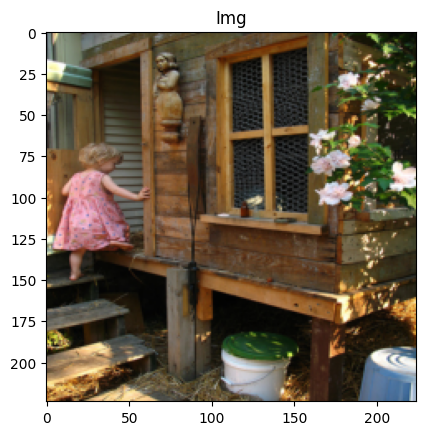

Token:  tensor([  1,   4,  28,   8,   4, 156, 224,  17,  32,  61,   4, 297,  11, 613,
          8,  24,   3, 425,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [28]:
img, caps = train_dataset[0]
show_image(img, "Img")
print("Token: ", caps)
print("Sentence: ")
print([train_dataset.vocab.int_to_str[token] for token in caps.tolist()])

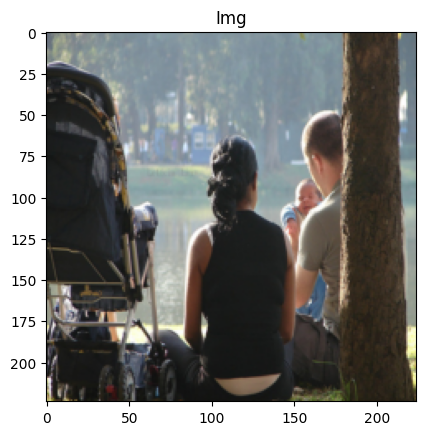

Token:  tensor([  1,   4,  16,   8,  25,   3,  19, 346, 762,  49,   6, 595,  19,  12,
         51,  26,   4, 165,  11,   4,  64,  49, 968,   5,   2])
Sentence: 
['<SOS>', 'a', 'couple', 'and', 'an', '<UNK>', ',', 'being', 'held', 'by', 'the', 'male', ',', 'sitting', 'next', 'to', 'a', 'pond', 'with', 'a', 'near', 'by', 'stroller', '.', '<EOS>']


In [29]:
img, caps = test_dataset[0]
show_image(img, "Img")
print("Token: ", caps)
print("Sentence: ")
print([test_dataset.vocab.int_to_str[token] for token in caps.tolist()])

# Collate class for Dataloader


In [30]:
class capsCollate:
  """
  Apply padding to captions with less length
  """
  def __init__(self, pad_idx, batch_first=False):
    self.pad_idx = pad_idx  # index of <PAD> token in our vocabulary
    self.batch_first = batch_first  # whether image is batch_size,C,H,W or C,H,W,batch_size

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]    # Adding an extra dimension (batch) to the images
    imgs = torch.cat(imgs, dim=0)   # Stacking the images across the 'batch' dimension

    targets = [item[1] for item in batch]   # Extracting captions
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx) # Adding padding to the captions

    return imgs, targets

# Train and test dataloaders

In [31]:
BATCH_SIZE = 4
NUM_WORKER = 1

pad_idx = train_dataset.vocab.str_to_int["<PAD>"]

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True)
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True)
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7977e7542440>,
 <torch.utils.data.dataloader.DataLoader at 0x7977e7537880>)

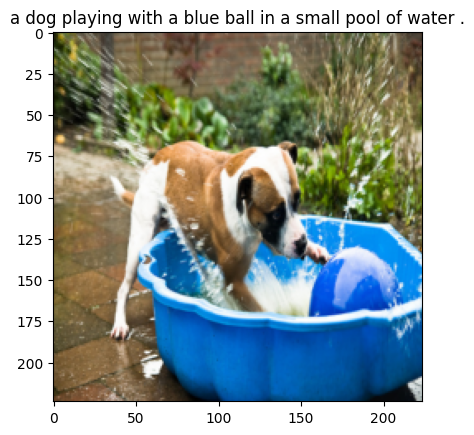

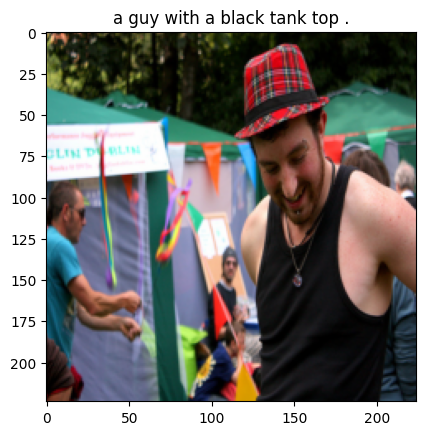

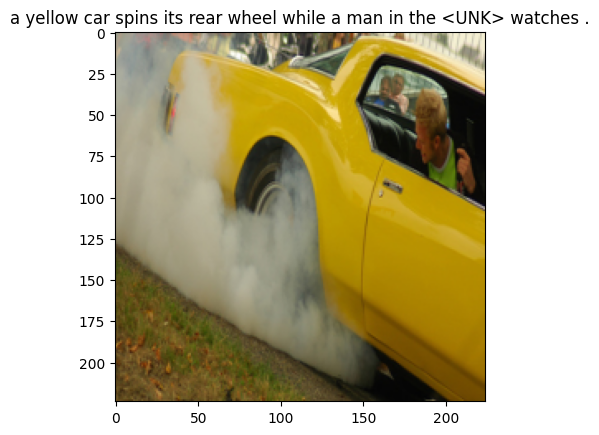

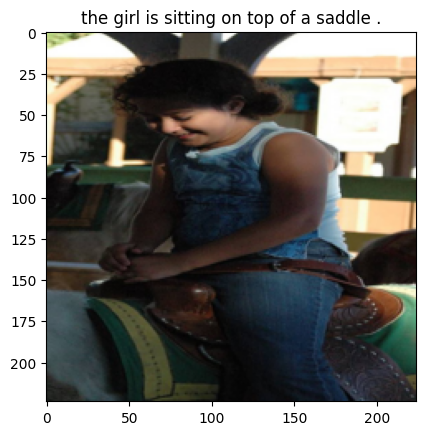

In [32]:
# Getting an iterator
dataiter = iter(train_dataloader)

# Taking the first batch
batch = next(dataiter)

imgs, caps = batch

for i in range(BATCH_SIZE):
  img, cap = imgs[i], caps[i]
  caption_label = [train_dataset.vocab.int_to_str[token] for token in cap.tolist()]
  eos_index = caption_label.index('<EOS>')
  caption_label = caption_label[1:eos_index]
  caption_label = " ".join(caption_label)
  show_image(img, caption_label)
  plt.show()

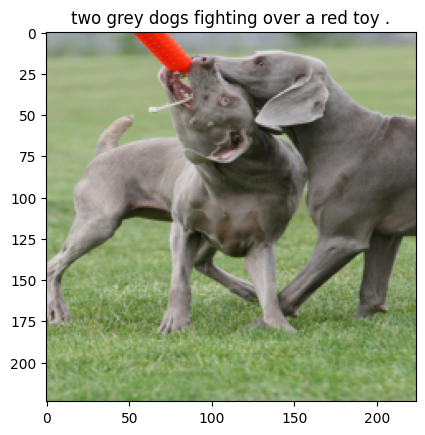

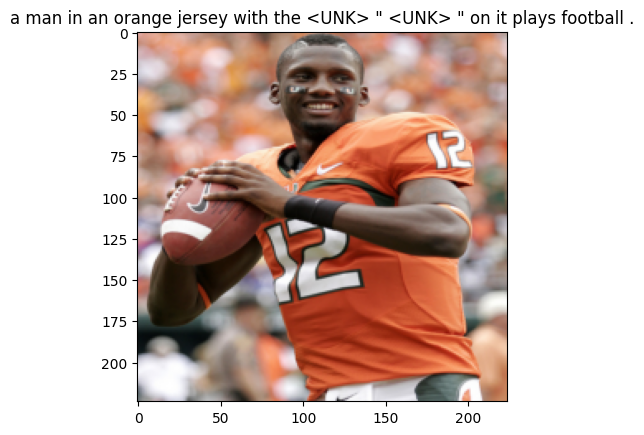

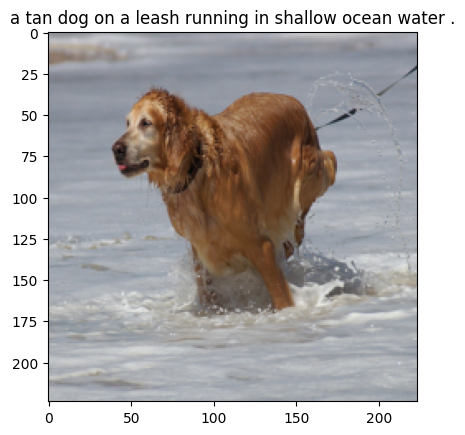

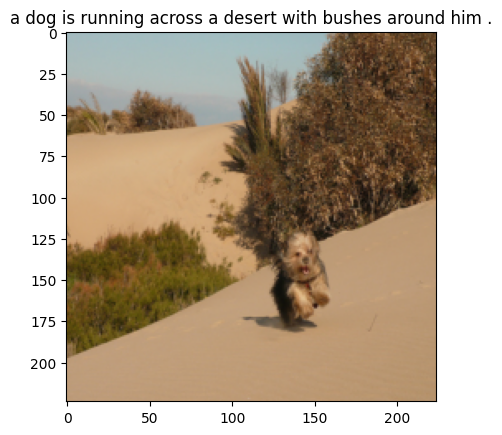

In [33]:
  # Getting an iterator
dataiter = iter(test_dataloader)

# Taking the first batch
batch = next(dataiter)

imgs, caps = batch

for i in range(BATCH_SIZE):
    img, cap = imgs[i], caps[i]
    caption_label = [test_dataset.vocab.int_to_str[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = " ".join(caption_label)
    show_image(img, caption_label)
    plt.show()

In [34]:
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [35]:
BATCH_SIZE=256
NUM_WORKER=2

img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # values of normalization as used in ImageNet dataset - so models like ResNet, VGG perform better with this type of normalization rather than just dividing by 255.0. First tuple shows mean of RGB channels and second tuple shows standard deviation of the same
])

In [36]:


train_dataset = FlickrDataset(
    root_dir = os.path.join(train_dir, "images"),
    captions_file = os.path.join(train_dir, "captions.txt"),
    transform = img_transforms
)

test_dataset = FlickrDataset(
    root_dir = os.path.join(test_dir, "images"),
    captions_file = os.path.join(test_dir, "captions.txt"),
    transform = img_transforms
)

In [37]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True)
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True)
)

# Improving Baseline Model

## Dataset and Transforms

In [38]:
# Image Transforms
img_transforms = transforms.Compose([
  transforms.Resize(320),
  transforms.CenterCrop(300),    # For efficientnet_B3
  transforms.RandomRotation((-90, 90)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # values of normalization as used in ImageNet dataset - so models like ResNet, VGG perform better with this type of normalization rather than just dividing by 255.0. First tuple shows mean of RGB channels and second tuple shows standard deviation of the same
])

data_path="/kaggle/input/flickr8k"
train_dir = os.path.join('/kaggle/working/', "train")
test_dir = os.path.join('/kaggle/working/', "test")

# Dataset
dataset = FlickrDataset(
    root_dir = os.path.join(data_path, "images"),
    captions_file = os.path.join(data_path, "captions.txt"),
    transform = img_transforms
)

# Training and Testing datasets
train_dataset = FlickrDataset(
    root_dir = os.path.join(train_dir, "images"),
    captions_file = os.path.join(train_dir, "captions.txt"),
    transform = img_transforms
)

test_dataset = FlickrDataset(
    root_dir = os.path.join(test_dir, "images"),
    captions_file = os.path.join(test_dir, "captions.txt"),
    transform = img_transforms
)

## Improved CNN+LSTM architecture

In [39]:
class Encoder(nn.Module):
  def __init__(self, embed_size, dropout_prob):
    super(Encoder, self).__init__()
    efficientnet = models.efficientnet_b3(pretrained=True)
    for param in efficientnet.parameters():
      param.requires_grad_(False)

    modules = list(efficientnet.children())[:-1]
    self.efficientnet = nn.Sequential(*modules)
    self.embed = nn.Linear(efficientnet.classifier[1].in_features, embed_size)
    self.batch_norm = nn.BatchNorm1d(embed_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, x):
    features = self.efficientnet(x)
    features = features.view(features.size(0), -1)
    embeddings = self.embed(features)
    embeddings = self.batch_norm(embeddings)
    return self.dropout(self.relu(embeddings))

In [40]:
class Decoder(nn.Module):
  def __init__(self, embed_size, dropout_prob, hidden_dim, num_layers, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
    self.fc = nn.Linear(in_features=hidden_dim, out_features=vocab_size)
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, features, captions):
    embeds = self.embedding(captions[:, :-1])
    x = torch.cat((features.unsqueeze(1), embeds), dim=1)
    x, _ = self.lstm(x)
    x = self.fc(x)
    return self.dropout(x)

  def generate_caption(self, inputs, hidden=None, max_len=20, vocab=dataset.vocab):
    """Inference - Given the image, generate caption"""
    batch_size = inputs.size(0)
    captions = []

    for i in range(max_len):
      output, hidden = self.lstm(inputs, hidden)
      output = self.fc(output)
      output = output.view(batch_size, -1)

      predicted_word_idx = output.argmax(dim=1)
      captions.append(predicted_word_idx.item())

      if vocab.int_to_str[predicted_word_idx.item()] == "<EOS>":
        break

      inputs = self.embedding(predicted_word_idx.unsqueeze(0))
    return [vocab.int_to_str[idx] for idx in captions]

In [41]:
class EncoderDecoderImproved(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_prob, num_layers):
    super().__init__()
    self.encoder = Encoder(embed_size=embedding_dim, dropout_prob=dropout_prob)
    self.decoder = Decoder(embed_size=embedding_dim, dropout_prob=dropout_prob, hidden_dim=hidden_dim, num_layers=num_layers, vocab_size=vocab_size)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

## Hyperparameter Tuning and Experiment Tracking

In [42]:
mlflow.end_run()
experiment_name = "Image_Captioning_Optimization_Kaggle_Improved_CNN_LSTM"

# Set the experiment
mlflow.set_experiment(experiment_name)

# Get the experiment ID again after setting it
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    print("Experiment not found, creating a new one.")
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

experiment_id = experiment.experiment_id
print(f"Using experiment: {experiment_id}")

mlflow.set_tracking_uri(f"file:///kaggle/working/mlflow_logs")
print("MLflow Tracking URI:", mlflow.get_tracking_uri())

2025/03/09 13:24:02 INFO mlflow.tracking.fluent: Experiment with name 'Image_Captioning_Optimization_Kaggle_Improved_CNN_LSTM' does not exist. Creating a new experiment.


Using experiment: 191435852074975169
MLflow Tracking URI: file:///kaggle/working/mlflow_logs


In [43]:
!ngrok config add-authtoken 2t4cn9RIy3Ml6CYjKYRUwVitqj0_6wCL9K3d9igPjtpjbGSrs

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [44]:
os.makedirs("mlruns", exist_ok=True)  # Ensure MLflow directory exists
mlflow_process = subprocess.Popen(["mlflow", "ui", "--port", "5000"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [45]:
mlflow_tunnel = ngrok.connect("5000", "http")
print("MLflow tracking UI is available at: ", mlflow_tunnel)

MLflow tracking UI is available at:  NgrokTunnel: "https://82a5-34-127-60-81.ngrok-free.app" -> "http://localhost:5000"


In [46]:
nltk.download('punkt')
# Define the directory
nltk_data_dir = os.path.join(os.path.expanduser("~"), "nltk_data")
# Ensure the directory exists
os.makedirs(nltk_data_dir, exist_ok=True)
# Download punkt if not already available
nltk.download('punkt', download_dir=nltk_data_dir)
# Append the path to nltk's search directories
nltk.data.path.append(nltk_data_dir)
print("NLTK Data Paths:", nltk.data.path)
print(nltk.data.find('tokenizers/punkt'))
os.environ["NLTK_DATA"] = nltk_data_dir

NLTK Data Paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/root/nltk_data', '/root/nltk_data']
/root/nltk_data/tokenizers/punkt


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
nltk.download('punkt')
import nltk
import os

# Define custom directory
nltk_data_dir = os.path.join(os.path.expanduser("~"), "nltk_data")

# Ensure the directory exists
os.makedirs(nltk_data_dir, exist_ok=True)

# Download 'punkt' explicitly to this directory
nltk.download('punkt', download_dir=nltk_data_dir)

# Add the directory to nltk's search path
nltk.data.path.append(nltk_data_dir)

# Check if the file exists
try:
    print(nltk.data.find('tokenizers/punkt'))
except LookupError:
    print("Punkt tokenizer is missing!")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...


/root/nltk_data/tokenizers/punkt


[nltk_data]   Package punkt is already up-to-date!


In [48]:
def objective(trial):
  # Ensure no active run
  if mlflow.active_run():
      mlflow.end_run()

  mlflow.set_experiment("Image_Captioning_Optimization_Kaggle_Improved_CNN_LSTM")  
  with mlflow.start_run():
    # Hyperparameters to be tuned
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    weight_decay = trial.suggest_float("weight decay", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])
    hidden_size = trial.suggest_int("hidden_size", 128, 1024, step=128)
    embedding_size = trial.suggest_int("embedding_size", 100, 512, step=50)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    mlflow.log_params({
        "learning_rate": learning_rate,
        "optimizer": optimizer,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "hidden_size": hidden_size,
        "embedding_size": embedding_size,
        "dropout_rate": dropout_rate,
        "num_layers": num_layers
    })

    mlflow.log_param("pruned", False)

    # Training and Testing DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True))

    # Initializing the model
    model = EncoderDecoderImproved(
        vocab_size=len(dataset.vocab),
        embedding_dim = embedding_size,
        hidden_dim = hidden_size,
        dropout_prob = dropout_rate,
        num_layers = num_layers
    ).to(device)

    loss_fn = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.str_to_int['<PAD>'])
    optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    vocab_size=len(train_dataset.vocab)
    bleu_metric = BLEUScore(n_gram=1, smooth=True)
    rouge_metric = ROUGEScore()

    num_epochs = 5
    for epoch in range(num_epochs):
      model.train()
      train_loss = 0
      for (images, captions) in iter(train_loader):
        images, captions = images.to(device), captions.to(device)
        outputs = model(images, captions)
        loss = loss_fn(outputs[:, :-1, :].reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      model.eval()
      test_loss, test_bleu, test_rouge = 0, 0, 0
      with torch.inference_mode():
        for (test_images, test_captions) in iter(test_loader):
          test_images, test_captions = test_images.to(device), test_captions.to(device)
          test_outputs = model(test_images, test_captions)
          test_loss += loss_fn(test_outputs.reshape(-1, test_outputs.shape[-1]), test_captions.view(-1)).item()

          test_features = model.encoder(test_images[0:1])
          pred_caption = model.decoder.generate_caption(test_features.unsqueeze(0), vocab=dataset.vocab)
          pred_caption_str = ' '.join(pred_caption)

          true_tokens = [test_dataset.vocab.int_to_str[idx.item()] for idx in test_captions[0] if idx.item() != dataset.vocab.str_to_int['<PAD>']]
          true_caption_str = ' '.join(true_tokens)

          test_bleu += bleu_metric(pred_caption, [true_tokens]).item()
          rouge_scores = rouge_metric(pred_caption_str, [true_caption_str])
          test_rouge += rouge_scores["rougeL_fmeasure"].item()
      
      test_loss /= len(test_loader)
      test_bleu /= len(test_loader)
      test_rouge /= len(test_loader)
      train_loss /= len(train_loader)

      mlflow.log_metric("epoch_train_loss", train_loss, step=epoch)
      mlflow.log_metric("epoch_test_loss", test_loss, step=epoch)
      mlflow.log_metric("epoch_test_rouge_score", test_rouge, step=epoch)
      mlflow.log_metric("epoch_test_bleu_score", test_bleu, step=epoch)

      trial.report(test_loss, epoch)
      if trial.should_prune():
        # mlflow.log_param("pruned", True)
        # mlflow.log_param("pruned_epoch", epoch)
        # mlflow.log_param("pruned_reason", "Optuna pruning triggered")
        raise optuna.exceptions.TrialPruned()

  # Save model and log in MLflow
  os.makedirs("models", exist_ok=True)
  model_path = f"models/trial_{trial.number}.pth"
  torch.save(model.state_dict(), model_path)
  mlflow.log_artifact(model_path)  # Log model in MLflow
  mlflow.end_run()
    
  return test_loss

In [49]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters", study.best_params)

[I 2025-03-09 13:24:06,837] A new study created in memory with name: no-name-f840c292-600c-4fbd-9aff-8801c8865b62
2025/03/09 13:24:06 INFO mlflow.tracking.fluent: Experiment with name 'Image_Captioning_Optimization_Kaggle_Improved_CNN_LSTM' does not exist. Creating a new experiment.
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [100, 512] and step=50, but the range is not divisible by `step`. It will be replaced by [100, 500].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Ef

Best Hyperparameters {'learning_rate': 0.018187374080166754, 'optimizer': 'RMSprop', 'weight decay': 2.8128200189244826e-05, 'batch_size': 16, 'hidden_size': 128, 'embedding_size': 100, 'dropout_rate': 0.30000000000000004, 'num_layers': 1}


In [50]:
runs = mlflow.search_runs()
print(runs)

                              run_id       experiment_id    status  \
0   00e6cb71d43c43e08a4bda18b3192a6d  308482987997693782    FAILED   
1   e818e2618c66488ea8a15c3d2793055a  308482987997693782    FAILED   
2   df123f954f7c422c93f32eaec2e093fa  308482987997693782    FAILED   
3   0c32fd551e28415ab346cd866c366bfa  308482987997693782    FAILED   
4   55ee7d31b87048e3955e85ac750bce09  308482987997693782    FAILED   
5   460968ebe6f44d83bba19dbac539da3b  308482987997693782  FINISHED   
6   c2c0fa1723f74947bb64ffcd23332c1a  308482987997693782  FINISHED   
7   41059a664f8a4d1eafd0634237c177e0  308482987997693782    FAILED   
8   2bc4323b9eac4dbcae231cbd8bb0a693  308482987997693782  FINISHED   
9   294d395d51b643048e9816dc0cffae53  308482987997693782  FINISHED   
10  31822766ebfc4789ac74d2197ec040d8  308482987997693782  FINISHED   
11  9cb6292526274b8ab562f3f3696d0046  308482987997693782  FINISHED   
12  6a0a533f6d1d4ca79c6317a8e0317c80  308482987997693782  FINISHED   
13  9d000e9a9e594443

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [51]:
# Download the logs and run them in the system
# mlflow ui --backend-store-uri file:///path/to/downloaded/mlflow_logs